Install MONAI


In [ ]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"

Import pkgs

In [ ]:
from monai.networks.nets import UNet
from monai.utils import first, set_determinism
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
import torch

Download example dataset...

In [ ]:
import os
import tempfile
from monai.apps import download_and_extract

directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

In [ ]:
import os
import glob

train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]

Set up train/test split applied at file level

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming data_dicts contains all your data
#train_files, val_files = train_test_split(data_dicts, test_size=0.2, random_state=42)
train_files, val_files = data_dicts[:-9], data_dicts[-9:]
print(len(train_files),len(val_files))

Set determinism for reproducibility...

In [ ]:
set_determinism(seed=0)

Set up transforms...

In [ ]:
# Define your transforms here
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    RandCropByPosNegLabeld(keys=["image", "label"], label_key="label", spatial_size=(96, 96, 96), pos=1, neg=1, num_samples=4, image_key="image", image_threshold=0),
])

val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
])

Create Dataset and Dataloders

In [ ]:
# Create dataset instances
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Define Model,
might need to change the stride to be an even divisor of the volume size (volume_size)%stride=0

In [ ]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [ ]:
from datetime import datetime

from google.colab import drive
drive.mount('/content/drive')


# Generate a timestamp
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

save_directory = '/content/drive/My Drive/UNet-T32-Spleen/Best_Models'  # Update 'your_directory' with your desired path
os.makedirs(save_directory, exist_ok=True)
save_path = os.path.join(save_directory, "best_metric_model_%s.pth" %timestamp)


Train Model

In [ ]:
max_epochs = 600
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, save_path))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/600


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/16, train_loss: 0.6680
2/16, train_loss: 0.6792
3/16, train_loss: 0.6834
4/16, train_loss: 0.6849
5/16, train_loss: 0.6857
6/16, train_loss: 0.6920
7/16, train_loss: 0.6590
8/16, train_loss: 0.6759
9/16, train_loss: 0.6681
10/16, train_loss: 0.6563
11/16, train_loss: 0.6539
12/16, train_loss: 0.6792
13/16, train_loss: 0.6526
14/16, train_loss: 0.6629
15/16, train_loss: 0.6517


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Streaming output truncated to the last 5000 lines.
6/16, train_loss: 0.0852
7/16, train_loss: 0.0291
8/16, train_loss: 0.1440
9/16, train_loss: 0.0859
10/16, train_loss: 0.2086
11/16, train_loss: 0.2656
12/16, train_loss: 0.0837
13/16, train_loss: 0.2053
14/16, train_loss: 0.1502
15/16, train_loss: 0.0667
16/16, train_loss: 0.2606
epoch 351 average loss: 0.1441
----------
epoch 352/600
1/16, train_loss: 0.2240
2/16, train_loss: 0.1415
3/16, train_loss: 0.2020
4/16, train_loss: 0.3261
5/16, train_loss: 0.2105
6/16, train_loss: 0.0828
7/16, train_loss: 0.0779
8/16, train_loss: 0.0887
9/16, train_loss: 0.1394
10/16, train_loss: 0.2007
11/16, train_loss: 0.2016
12/16, train_loss: 0.0806
13/16, train_loss: 0.1471
14/16, train_loss: 0.2607
15/16, train_loss: 0.3802
16/16, train_loss: 0.1459
epoch 352 average loss: 0.1819
current epoch: 352 current mean dice: 0.9395
best mean dice: 0.9456 at epoch: 282
----------
epoch 353/600
1/16, train_loss: 0.0873
2/16, train_loss: 0.2019
3/16, train_loss

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")


train completed, best_metric: 0.9513 at epoch: 566


In [ ]:
import matplotlib.pyplot as plt

Plot Loss Curves

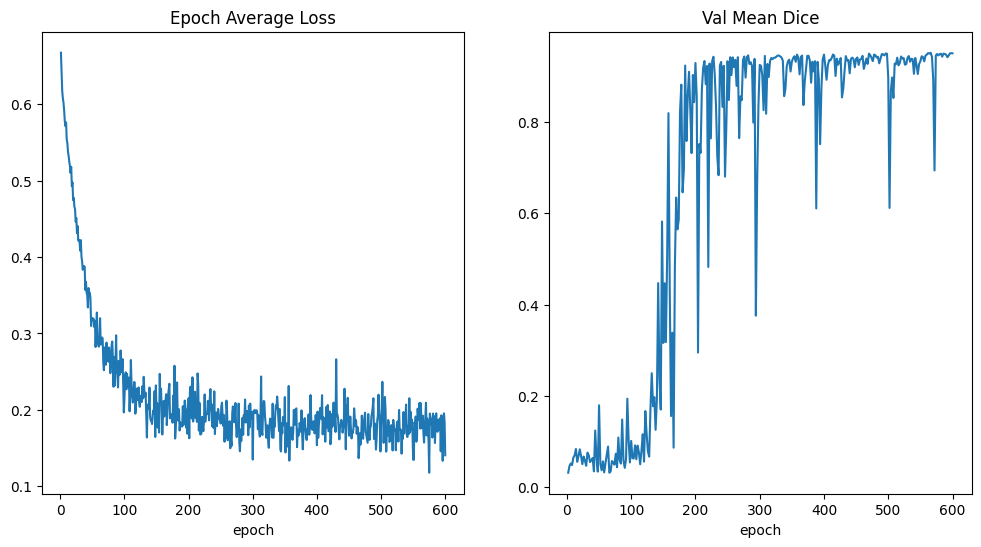

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

Add Infernce Class

In [ ]:
import torch

class Inference:
    def __init__(self, model, device):
        """
        Initialize the Inference class.

        :param model: Trained model for inference.
        :param device: Device to perform inference on ('cuda' or 'cpu').
        """
        self.model = model.to(device)
        self.device = device
        self.model.eval()

    def predict(self, volumes, threshold=0.5, return_probabilities=False):
        """
        Predict the segmentation mask for the input volumes.

        :param volumes: A batch of input volumes.
        :param threshold: Threshold to convert probabilities to binary mask.
        :param return_probabilities: If True, return the raw probability maps.
        :return: Segmentation masks or probability maps for the input volumes.
        """
        # Ensure input is a tensor and transfer it to the specified device
        volumes = volumes.to(self.device)

        # Forward pass
        with torch.no_grad():
            outputs = self.model(volumes)

        if return_probabilities:
            return outputs.cpu()

        # Apply threshold to get the binary masks
        masks = outputs > threshold
        return masks.squeeze(1).cpu()  # Assuming channel dimension is at position 1

In [ ]:
import matplotlib.pyplot as plt

def plot_volume_and_mask(volume, mask, slice_indices, save_path=None):
    # Ensure the tensors are detached and moved to CPU
    volume_np = volume.detach().cpu().numpy()
    mask_np = mask.detach().cpu().numpy()

    num_slices = volume_np.shape[-1]  # Assuming depth is the last dimension
    num_rows = len(slice_indices)
    num_cols = 2  # One for volume, one for mask

    fig, ax = plt.subplots(num_rows, num_cols, figsize=(10, 5 * num_rows))

    for i, slice_index in enumerate(slice_indices):
        if slice_index < 0 or slice_index >= num_slices:
            raise ValueError(f"Slice index {slice_index} is out of bounds for volume with depth {num_slices}")

        # Display the volume slice
        ax[i, 0].imshow(volume_np[..., slice_index], cmap='gray')
        ax[i, 0].set_title(f"Volume Slice {slice_index}")

        # Display the mask slice
        ax[i, 1].imshow(volume_np[..., slice_index], cmap='gray')
        ax[i, 1].imshow(mask_np[..., slice_index], alpha=0.5, cmap='viridis')  # Overlay mask
        ax[i, 1].set_title(f"Mask Slice {slice_index}")

    plt.tight_layout()
    plt.savefig(save_path, format='pdf')

    return fig

Do inference on a single sample

In [ ]:
# Predict the mask using the padded volume
model.load_state_dict(torch.load(save_path))
model.eval()


roi_size = (160, 160, 160)
sw_batch_size = 4

val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)

ValueError: fname must be a PathLike or file handle

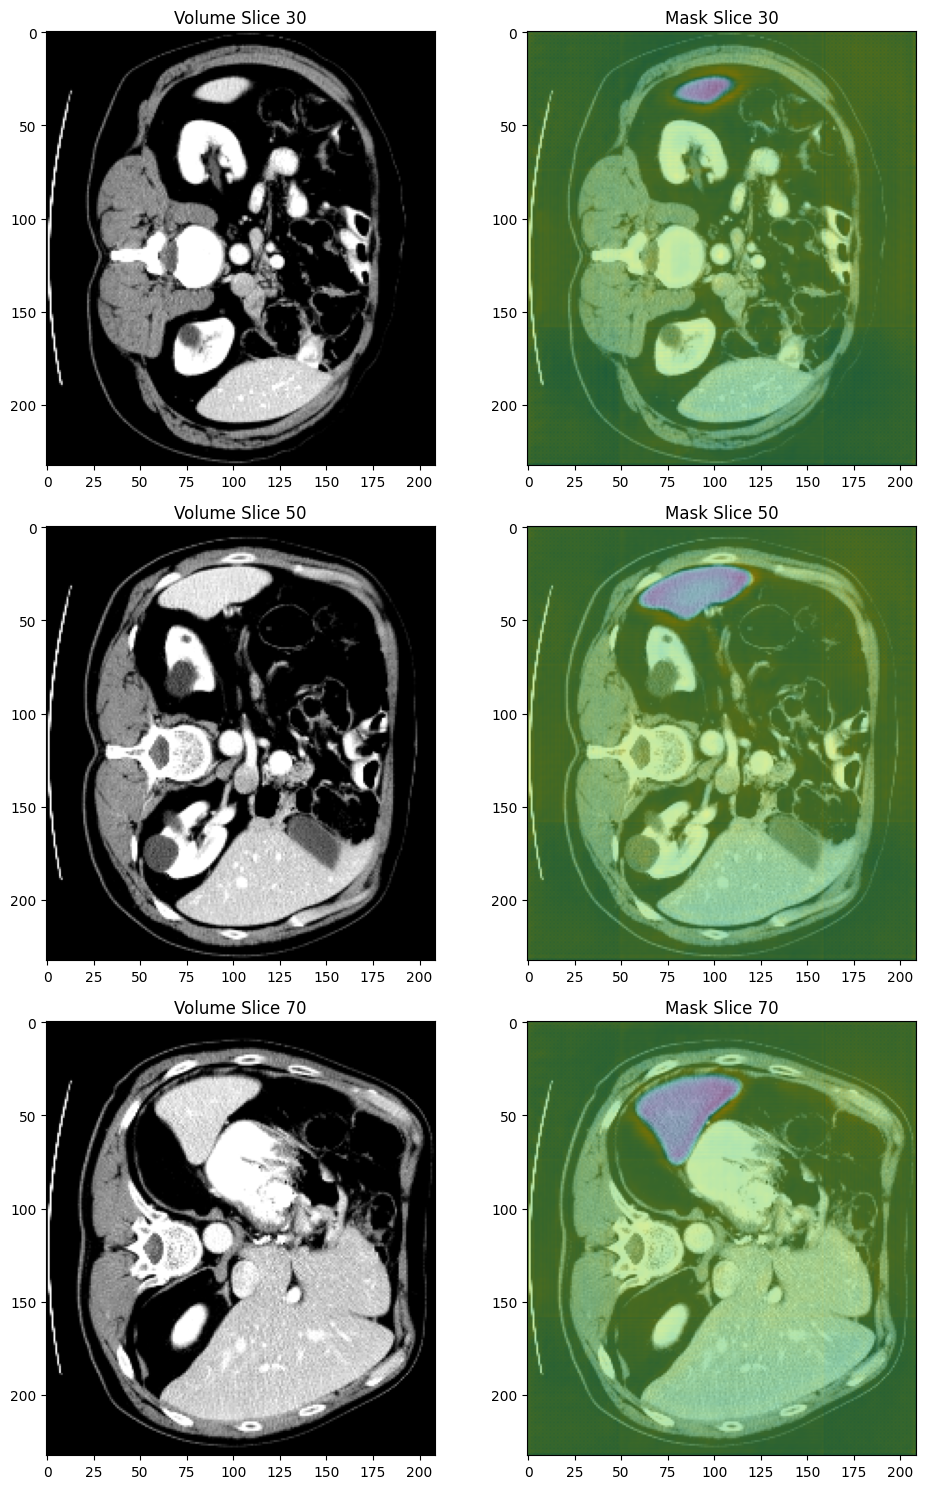

In [ ]:
volume = val_data["image"]
predicted_mask = val_outputs  # Output from sliding_window_inference
# Assuming volume and predicted_mask are 4D tensors with shape [batch_size, channels, height, width]
# and you want to visualize the first item in the batch
plot_volume_and_mask(volume[0, 0], predicted_mask[0, 0], slice_indices=[30, 50, 70])
